In [20]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la
from kneed import KneeLocator 
from scipy.optimize import curve_fit
from numpy import linalg

## Probability distribution function, $h(\vec{y})$ of the equilibrium. 
Given in the Equation (4) of the paper

In [ ]:
# This PDF was very complex so comments are added for extra clarity but it needs to read with supplementary 1 to be able to follow along
def sampled_PDF_generic(A, sd_matrix, equilibrium, y, sample_size):
    """
    Compute the PDF h(y) from Eq. (4),
    The inputs are:
      A: Mean interaction matrix (NxN)
      sd_matrix: Matrix of std devs for noise (NxN)
      equilibrium: The noise-free equilibrium x (length N)
      y: The point at which we evaluate the PDF (length N)
      sample_size: Number of samples to draw to estimate of expectation value term
    """
    N = len(equilibrium)
    A = np.asarray(A, dtype=float)
    sd_matrix = np.asarray(sd_matrix, dtype=float)
    equilibrium = np.asarray(equilibrium, dtype=float)
    y = np.asarray(y, dtype=float)

    # 1) Build the F array of shape (N, N, N)
    F = np.zeros((N, N, N), dtype=float)
    for m in range(N):
        for i in range(N):
            for j in range(N):
                for k in range(N):
                    F[m, i, j] += (A.T[i, k] * A[k, j]) / (sd_matrix[k, m] ** 2)

    # 2) Compute the constant term K
    K = 0.0
    for i in range(N):
        beta_i = (equilibrium[i] - y[i]) / y[i]
        for k in range(N):
            K += ((A.T[i, k] * A[k, i]) / (sd_matrix[k, i] ** 2)) * (beta_i ** 2)

    # 3) Form psi
    psi_list = []
    for i in range(N):
        beta_i = (equilibrium[i] - y[i]) / y[i]
        for q in range(N):
            if q == i:
                continue
            beta_q = (equilibrium[q] - y[q]) / y[q]
            val = 2.0 * (beta_i * F[i, i, q] - beta_q * (y[i] / y[q]) * F[q, q, q])
            psi_list.append(val)
    psi = np.array(psi_list, dtype=float) 

    # 4) Build the full H matrix (size N^2 x N^2)
    big_size = N * N
    H = np.zeros((big_size, big_size), dtype=float)
    for block_row in range(big_size):
        l = block_row // N  # row index of B in the block
        j = block_row % N   # column (block) index of B
        for block_col in range(big_size):
            i = block_col // N  # row index from block
            k = block_col % N   # column index from block
            # Only fill entries corresponding to off diagonal elements
            if (l == j) or (i == k):
                # Skip diagonal entries of B
                continue
            # Now fill H[block_row, block_col]
            kr_li = 1.0 if (l == i) else 0.0
            kr_ij = 1.0 if (i == j) else 0.0
            kr_jk = 1.0 if (j == k) else 0.0

            term1 = F[i, j, k] * (kr_li - 2.0 * (y[l] / y[i]) * kr_ij)
            term2 = F[j, j, j] * ((y[l] * y[i]) / (y[j]**2)) * kr_jk
            H[block_row, block_col] = term1 + term2

    # Build a mask for indices corresponding to off diagonals
    mask = np.array([((r // N) != (r % N)) for r in range(big_size)], dtype=bool)
    H_truncated = H[np.ix_(mask, mask)]
    # Symmetrize the truncated matrix to get Gamma
    Gamma = 0.5 * (H_truncated + H_truncated.T)

    # 5) Compute mu and zeta
    Gamma_inv = la.inv(Gamma)
    if Gamma.shape[0] != len(psi):
        raise ValueError(f"Size mismatch: Gamma is {Gamma.shape[0]}x{Gamma.shape[1]} but psi length is {len(psi)}. Check the diagonal removal logic.")
    mu = -0.5 * (Gamma_inv @ psi)
    zeta = K - (mu @ Gamma @ mu)

    # 6) Monte Carlo sampling to estimate E[|I + Omega|].
    # Omega is the NxN matrix 
    mu_t = mu.transpose()
    mu_1d = np.ravel(mu_t)

    w_samples = np.random.multivariate_normal(mean=mu_1d, cov=Gamma_inv, size=sample_size)
    abs_det_sum = 0.0
    for s in range(sample_size):
        w_vec = w_samples[s, :]
        Omega = np.zeros((N, N), dtype=float)
        idx = 0
        # Fill off diagonals in the same ordering as in psi
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                Omega[i, j] = w_vec[idx]
                idx += 1
        Omega = Omega.transpose()
        # Set the diagonal entries
        for i in range(N):
            sum_offdiag = sum(Omega[i, j] * y[j] for j in range(N) if j != i)
            Omega[i, i] = (equilibrium[i] - y[i] - sum_offdiag) / y[i]
        mat = np.eye(N) + Omega
        abs_det_sum += abs(la.det(mat))
    mean_abs_det = abs_det_sum / sample_size

    # 7) Assemble the final PDF value
    detA = la.det(A)
    detGammaInv = la.det(Gamma_inv)

    factor = ((abs(detA) ** N) *
              ((2.0 * np.pi) ** (-N / 2.0)) *
              np.sqrt(abs(detGammaInv)) *
              np.exp(-0.5 * zeta) *
              mean_abs_det)

    denom = np.prod(sd_matrix) * np.prod(y)
    h_val = factor / denom
    
    return h_val

### Gaussian approximation function

In [28]:
def covariance(x, sigma, A):
    R = linalg.inv(A)
    N = len(x)
    covariance = []
    for i in range(N):
        cov_i = []
        for j in range(N):
            cov_ij = 0
            for k in range(N):
                for p in range(N):
                    cov_ij += x[k]**2 * sigma[p, k]**2 * R[i,p]*R[j,p]
            cov_i.append(cov_ij) 
        covariance.append(cov_i)
    return covariance

def gaussian_app(mean, xaxis, cov):
    cov_inv = np.linalg.inv(cov)
    det_cov = np.linalg.det(cov)
    normalization = 1 / (2 * np.pi * np.sqrt(det_cov))
    pdf_values = np.zeros(len(xaxis))
    for i in range(len(xaxis)):
        diff = np.subtract([xaxis[i], xaxis[i]], mean)
        exponent = -0.5 * (np.dot(diff.T, np.dot(cov_inv, diff)))
        p = normalization * np.exp(exponent)
        pdf_values[i] = p
    return pdf_values

### Distribution shown along the main diagonal for $N=2$ case with Gaussian approximation

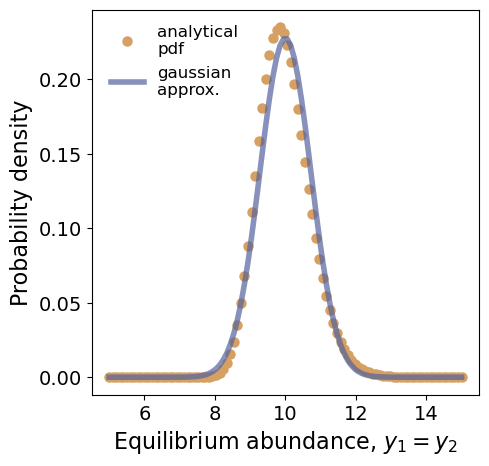

In [ ]:
A = [[-1.4, 0.1],
     [0.5, -1.4]]
equilibrium = [10, 10]

diffusion = 0.05* np.abs(A)
D = np.square(diffusion)
drift = 1.0
k = drift

sigma = np.sqrt(D/(2*k))
sigma = 0.08*np.abs(A)

averaging_sample_size = 1000

#Plotting the PDF along main diagonal around maximum
taillimits = (5.0, 15.0)
xaxisnum = 100
xaxis = np.linspace(taillimits[0], taillimits[1], xaxisnum)
PDFvals = [sampled_PDF_generic(A, sigma, equilibrium, [i for j in range(len(equilibrium))], averaging_sample_size) for i in xaxis]

cov = covariance(equilibrium, sigma, A)
mean = equilibrium # first order
gaussian_fit = gaussian_app(mean, xaxis, cov)

# Create the figure
plt.figure(figsize=(5, 5))
plt.plot(xaxis, PDFvals, '.', label='analytical' + '\n' 'pdf', color='#d5a062', markersize=13, alpha = 1.0)

plt.plot(xaxis, gaussian_fit, '-', label='gaussian' + '\n' + 'approx.', color='#55639e', linewidth=4, alpha = 0.7)

plt.xlabel(r'Equilibrium abundance, $y_1=y_2$', fontsize=16)
plt.ylabel('Probability density', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
# plt.title('Comparison of Probabilities (low noise, $\sigma = 0.2$)')
plt.legend(frameon=False, fontsize=12, loc = 'upper left', bbox_to_anchor=(0.01, 1))
#plt.xlim([0.75,1.5])
#plt.ylim([-140,5])
plt.grid(False)
#plt.savefig('figures/gaussian_fit_maximum.png', bbox_inches='tight', dpi=1100)
plt.show()

### Plotting tails of the distribution for any ecosystem given in parameters.txt. To change the ecosystem use find_params.ipynb

In [44]:
# Import parameters from parameters.txt file. Use find_params.ipynb to create such .txt file
with open('parameters.txt', 'r') as f:
    lines = f.readlines()
N = int(lines[0].strip().split('=')[1])
A_start = lines.index('A = \n') + 1
A = np.loadtxt(lines[A_start:A_start + N])
equilibrium_start = lines.index('equilibrium = \n') + 1
equilibrium = np.loadtxt(lines[equilibrium_start:equilibrium_start + N])

# Set the noise level
diffusion = 1.0 * np.abs(A)
D = np.square(diffusion)
drift = 1.0
k = drift

sigma = np.sqrt(D/(2*k))

# Sample number for the expectation value used in the PDF
averaging_sample_size = 10000
#sampled_PDF_generic(A, sigma, equilibrium, equilibrium, averaging_sample_size)

In [45]:
#Plotting the PDF along main diagonal through tails
xaxis= np.geomspace(10, 10**10, 50)
logxaxis = np.log10(xaxis)
PDFvals = [sampled_PDF_generic(A, sigma, equilibrium, [i for j in range(len(equilibrium))], averaging_sample_size) for i in xaxis]
logPDFvals = np.log10(PDFvals)

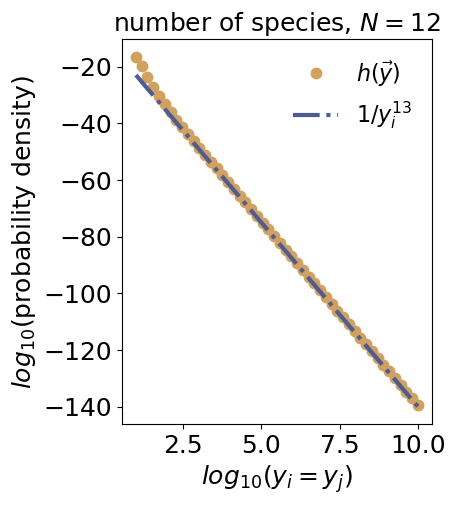

In [46]:
def tail_fit(x, constant):
    return [constant/i**(len(equilibrium)+1) for i in x]

fit_yaxis = np.log10(tail_fit(xaxis, 1e-10))

plt.figure(figsize=(4, 5))
plt.plot(logxaxis, logPDFvals, '.', color='#d1a15d', markersize=15, label=r'$h(\vec{y})$')
plt.plot(logxaxis, fit_yaxis, '-.', label=f'$1/y_i^{{{N+1}}}$', color='#4c5c96', lw=3)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('number of species, $N=$' + str(len(equilibrium)), fontsize=18)
plt.xlabel(r'$log_{10} (y_i=y_j)$', fontsize=18)
plt.ylabel('$log_{10}$(probability density)', fontsize=18)
plt.legend(frameon=False, fontsize=16)
plt.grid(False)
plt.show()

### Distribution shown as contour map (only use for two species systems, $N=2$)

In [38]:
N = 2
A = [[-1.4, 0.1],
     [0.5, -1.4]]
equilibrium = [10, 10]

diffusion = 0.05* np.abs(A)
D = np.square(diffusion)
drift = 1.0
k = drift

sigma = np.sqrt(D/(2*k))
sigma = 0.08*np.abs(A)

# Set the bounds for y1 and y2. Make sure mesh does not include origin.
y1_min, y1_max = 7.5, 12.5
y2_min, y2_max = 7.5, 12.5

#Using the above parameters find PDF values through a mesh
mesh_size = 100
Y1 = np.linspace(y1_min, y1_max, mesh_size)
Y2 = np.linspace(y2_min, y2_max, mesh_size)

Y1, Y2 = np.meshgrid(Y1, Y2)

P = np.zeros([mesh_size,mesh_size])

for i in range(mesh_size):
    for k in range(mesh_size):
        P[i,k] = sampled_PDF_generic(A, sigma, equilibrium, [Y1[i,k], Y2[i,k]], sample_size=1000)

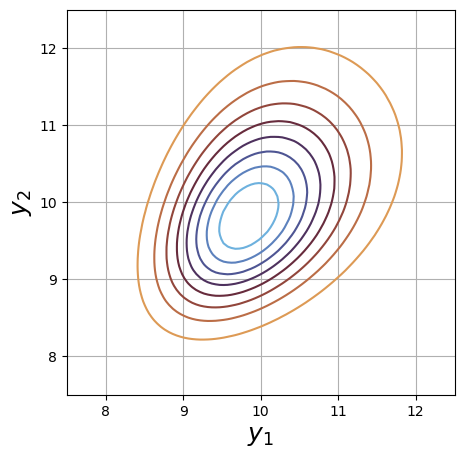

In [39]:
plt.figure(figsize=(5, 5))

contour = plt.contourf(Y1, Y2, P, colors='white') 

# Define contour levels and colors
levels = np.linspace(np.min(P), np.max(P), 10)
colors = plt.cm.managua(np.linspace(0, 1, len(levels)))

contour_lines = plt.contour(Y1, Y2, P, levels=levels, colors=colors)

# Set labels and title
plt.xlabel('$y_1$', fontsize=18)
plt.ylabel('$y_2$', fontsize=18)
#plt.title('PDF from Expectation Value', fontsize=14)
# plt.xticks([-1.0, -0.5, 0.0, 0.5, 1.0],fontsize=18)
# plt.yticks([-1.0, -0.5, 0.0, 0.5, 1.0],fontsize=18)
plt.grid()
#plt.savefig('figures/contour_high_noise.png', bbox_inches='tight', dpi=1100)
plt.show()

## Critical noise levels leading to almost certain feasibility loss

In [47]:
def ext_stoc_sim(x, A, D, k, samp):
    r = -np.dot(A, x)
    N = len(x)
    variance = D/(2*k)
    W = np.random.normal(loc=0, scale=np.sqrt(variance), size=(samp, N, N))
    A_noises = A + W
    y_values = -np.matmul(np.linalg.inv(A_noises), np.tile(r, (samp, 1)).reshape(samp, N, 1))
    
    ext = 0
    for i in range(len(y_values)):
        coords = y_values[i, :, 0]
        if np.any(coords <= 0):     # Check if any coordinate is <= 0
            ext += 1
    prob = ext / samp
    if prob == 0:
        return 0
    return prob

In [48]:
with open('parameters.txt', 'r') as f:
    lines = f.readlines()
N = int(lines[0].strip().split('=')[1])
A_start = lines.index('A = \n') + 1
A = np.loadtxt(lines[A_start:A_start + N])
equilibrium_start = lines.index('equilibrium = \n') + 1
equilibrium = np.loadtxt(lines[equilibrium_start:equilibrium_start + N])
k = 1.0 # taken same across the simulation

#Find range of parameters to be used for analysis
for diffusion in np.linspace(0.001, 0.1, 25): #adjust these values if needed. They are rough estimates of where can the lower boundary be
    if ext_stoc_sim(equilibrium, A, diffusion, k, 5000)>=0.01:
        print('lower boundary start:')
        print('diffusion constant: ' + str(diffusion) + ', probability of feasibility loss: ' +  str(ext_stoc_sim(equilibrium, A, diffusion, k, 5000)))
        lower_boundary = diffusion
        break
        
for diffusion in np.linspace(0.01, 5.0, 25): #adjust these values if needed. They are rough estimates of where can the upper boundary be
    if ext_stoc_sim(equilibrium, A, diffusion, k, 5000)>=((1-1/2**len(equilibrium))-0.01):
        print('upper boundary stop:')
        print('diffusion constant: ' + str(diffusion) + ', probability of feasibility loss: ' +  str(ext_stoc_sim(equilibrium, A, diffusion, k, 5000)))
        upper_boundary = diffusion
        break

lower boundary start:
diffusion constant: 0.029875000000000002, probability of feasibility loss: 0.0154
upper boundary stop:
diffusion constant: 2.7129166666666666, probability of feasibility loss: 0.9914


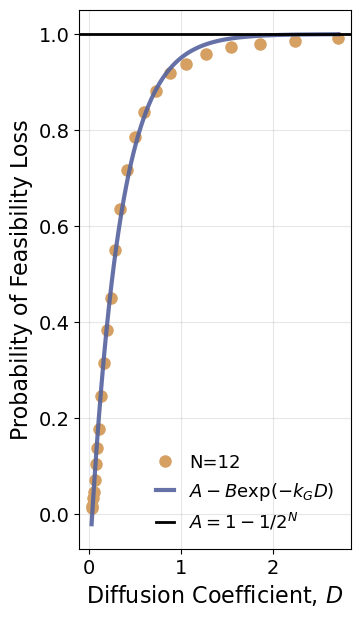

ecosystem size is: N = 12
fitted parameters: kG = 3.1113, B = 1.1209
at this point, the probability of feasibility loss is: 0.8777


In [49]:
diffusion_array=np.geomspace(lower_boundary, upper_boundary, 25)
prob = []
for diffusion in diffusion_array:
    prob.append(ext_stoc_sim(equilibrium, A, diffusion, k, 5000))

def exp_saturation(x, kG, B):
    A = 1 - 1/2**N 
    return A - B*np.exp(-kG * x)

# Main analysis
prob = np.array(prob)
sorted_indices = np.argsort(diffusion_array)
diffusion_array_sorted = diffusion_array[sorted_indices]
prob_sorted = prob[sorted_indices]

# Fit the curve to the data
popt, pcov = curve_fit(exp_saturation, diffusion_array_sorted, prob_sorted, method='trf')
kG_opt, B_opt = popt

# Create a smooth curve for plotting and knee-finding
diffusion_fine = np.linspace(min(diffusion_array), max(diffusion_array), 500)
prob_fitted = exp_saturation(diffusion_fine, kG_opt, B_opt)

# The kneelocator needs x and y values.
kneedle = KneeLocator(
    x=diffusion_fine,
    y=prob_fitted,
    S=1.0,  # Sensitivity parameter
    curve="concave",
    direction="increasing"
)

# The knee point x
knee_x = kneedle.knee
# The knee point y
knee_y = kneedle.knee_y

plt.figure(figsize=(3.5, 7))
plt.plot(diffusion_array_sorted, prob_sorted, 'o', label=fr'N=' + str(N), color='#d5a062', markersize = 8, alpha = 1.0)
plt.plot(diffusion_fine, prob_fitted, '-', label=fr'$A- B \exp (-k_G D)$', color='#55639e', linewidth=3 ,alpha = 0.9)
plt.axhline(y=(1 - 1/(2**N)), color='black', linestyle='-', label='$A = 1-1/2^N$', linewidth = 2)

# # Plot knee point
# if knee_x is not None:
#     plt.plot(knee_x, knee_y, "+", mew=2, color='black', markersize=12, label=fr'$\kappa$ = {knee_x:.2f} (Knee)', alpha=1)

plt.xlabel('Diffusion Coefficient, $D$', fontsize = 16)
plt.ylabel('Probability of Feasibility Loss', fontsize = 16)
plt.legend(frameon=False, fontsize = 13, handlelength = 1)
plt.grid(True, linestyle='-', alpha=0.3)
plt.tick_params(labelsize = 14)
plt.savefig("P_vs_D_exp_fit.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"ecosystem size is: N = {N}")
print(f"fitted parameters: kG = {kG_opt:.4f}, B = {B_opt:.4f}")

if knee_x is not None:
    #print(f"Knee of the curve is at a noise: {knee_x:.4f}")
    print(f"at this point, the probability of feasibility loss is: {knee_y:.4f}")
else:
    print("could not find a knee point for the given curve.")